<H3> Astrometry quality checks </H3>

The idea is to compute the distribution of the angular distances between matched sources from a set of exposures covering the same area. We arbitrarily take the first exposure as a reference.

The angular distance is computed:
<OL>
<LI> using the source coordinates associated to the "src" catalog, thus corresponding to the standard astrometric solution (fit using an external reference catalog only)</LI>
<LI> using the updated WCS from the simultaneous astrometry fit</LI>
</OL>

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.coord as afwCoord
import numpy as np
import math

from astropy.table import Table

# List of visits to be considered
# visits = [7274, 7276, 7420, 7422, 14108, 14112, 38074, 38080]
# visits = [11690, 11700, 11710, 29324, 29350]
visits = [1202, 1204, 1206, 1208, 1210]

# Reference visit
ref = 1202

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
ccd = range(104)

filter = 'HSC-R'

fluxType = "base_PsfFlux"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
#butler = dafPersist.Butler("/sps/lsst/dev/lsstprod/hsc/SSP_UDEEP_COSMOS/output/rerun/_parent/rerun")
butler = dafPersist.Butler("/sps/lsst/users/lsstprod/hsc/SSP_UDEEP_COSMOS/output2")
    
calibRef = [None]*104
oldWcsRef = [None]*104
newWcsRef = [None]*104

T = Table(names=("id", "dist", "disto", "visit", "ccdRef", "ccdVis", "mag", "ra", "dec"), 
          dtype=('i','f', 'f', 'i', 'i2', 'i2', 'f', 'S12', 'S12'))

for indx, c in enumerate(ccd) :
    if c == 9:
        continue
        
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print(c, len(oldSrc))
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record 
        # the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=np.int32, doc="CCD number")

        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
        srcRef.reserve(5000000)

    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)
        
    # retrieve the calibration object associated to the CCDs
    mdRef = butler.get("calexp_md", dataid, immediate=True)
    calibRef[c] = afwImage.Calib(mdRef)
    # retrieve the original and improved wcs
#    oldWcsRef[c] = afwImage.makeWcs(mdRef)
    oldWcsRef[c] = afwGeom.makeSkyWcs(mdRef)
    dataidNew = {'visit':ref, 'filter':filter, 'ccd':c, 'tract':tract}
    newWcsRefCont = butler.get('wcs', dataidNew, immediate=True)
    newWcsRef[c] = newWcsRefCont.getWcs()

print("Ref...", len(srcRef))
    
# Store original and updated Wcs associated to each visit / ccd
oldWcsVis = {}
newWcsVis = {}
for v in visits :
    oldWcsVis[v] = [None]*104
    newWcsVis[v] = [None]*104
    for c in ccd :
        if c == 9:
            continue
        if v == 38074 and c == 77:
            continue
        if v == 1206 and c == 77:
            continue
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        dataidNew = {'visit':v, 'filter':filter, 'ccd':c, 'tract':tract}
        mdVis = butler.get("calexp_md", dataid, immediate=True)
#        oldWcsVis[v][c] = afwImage.makeWcs(mdVis)
        oldWcsVis[v][c] = afwGeom.makeSkyWcs(mdVis)
        newWcsVisCont = butler.get('wcs', dataidNew, immediate=True)
        newWcsVis[v][c] = newWcsVisCont.getWcs()

mag = []
oldDist = []
newDist = []
oldRaDif = []
oldDecDif = []
newRaDif = []
newDecDif = []
xSig = []
ff = 0
for indV, v in enumerate(visits) :
    if v == ref :
        continue
    if ff == 0 :
        ff = 1
    for indC, c in enumerate(ccd) :
        if c == 9:
            continue
        if v == 38074 and c == 77:
            continue
        if v == 1206 and c == 77:
            continue
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        src = butler.get('src', dataid, immediate=True)

        match = afwTable.matchRaDec(srcRef, src, afwGeom.Angle(1./3600., afwGeom.degrees))

        schemaRef = srcRef.getSchema()
        if ff == 1 and indC == 0 :
            ff = 2
            schemaSrc = src.getSchema()
            flagKeyRef = []
            flagKeyVis = []
            for f in Flags :
                keyRef = schemaRef[f].asKey()
                flagKeyRef.append(keyRef)
                keyVis = schemaSrc[f].asKey()
                flagKeyVis.append(keyVis)

            extendKey = newSchema["base_ClassificationExtendedness_value"].asKey()
            fluxKey = newSchema[fluxType + "_flux"].asKey()
            fluxSigmaKey = newSchema[fluxType + "_fluxSigma"].asKey()
            ccdKeyRef = newSchema["ccd"].asKey()
            
            xSigmaKey = schemaSrc["base_SdssCentroid_xSigma"].asKey()
            ySigmaKey = schemaSrc["base_SdssCentroid_ySigma"].asKey()
            mxxKey = schemaSrc["base_SdssShape_xx"].asKey()
            myyKey = schemaSrc["base_SdssShape_yy"].asKey()
            mxyKey = schemaSrc["base_SdssShape_xy"].asKey()              

        for m in match :
            mRef = m.first
            mVis = m.second

            for f in flagKeyRef :
                rej = 0
                if mRef.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
            for f in flagKeyVis :
                rej = 0
                if mVis.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
                    
            # cleanup the reference sources in order to keep only decent star-like objects
            if mRef.get(extendKey) >= 0.5 :
                continue

            ang = afwGeom.radToMas(m.distance)

            # retrieve the CCD corresponding to the reference source
            ccdRef = mRef.get(ccdKeyRef)
            ccdVis = c

            # compute magnitude
            calib = calibRef[ccdRef]
            flux = mRef.get(fluxKey)
            fluxSigma = mRef.get(fluxSigmaKey)
            if flux /fluxSigma < 5 :
                continue
            if flux > 0. :
                refMag = calib.getMagnitude(flux)
            else :
                continue
            if refMag < 16.5 or refMag > 26 :
                continue

            footprint = mVis.getFootprint()
            if footprint is not None and len(footprint.getPeaks()) > 1 :
                continue
                
            # Check consistency of the source covariance parameters
            vx = np.square(mVis.get(xSigmaKey))
            vy = np.square(mVis.get(ySigmaKey))
            mxx = mVis.get(mxxKey)
            myy = mVis.get(myyKey)
            mxy = mVis.get(mxyKey)
            vxy = mxy*(vx+vy)/(mxx+myy)
            if (vxy*vxy)>(vx*vy) or np.isnan(vx) or np.isnan(vy):
                print("Error in covariance : ", v, c, ccdRef, vxy*vxy, vx*vy, vx, vy, mVis.get("base_SdssCentroid_flag"), mVis.get("base_SdssShape_flag")) 
                print(mVis.get(xSigmaKey), mVis.get(ySigmaKey), mxx, myy, mxy)
                print(mVis.get("base_SdssCentroid_x"), mVis.get("base_SdssCentroid_y"))
                continue

            oldCoordRef = mRef.getCoord()
            pixelsRef = oldWcsRef[ccdRef].skyToPixel(afwCoord.IcrsCoord(oldCoordRef.getRa(), oldCoordRef.getDec()))
            newCoordRef = newWcsRef[ccdRef].pixelToSky(pixelsRef).toIcrs()

            oldCoordVis = mVis.getCoord()
            pixelsVis = oldWcsVis[v][c].skyToPixel(afwCoord.IcrsCoord(oldCoordVis.getRa(), oldCoordVis.getDec()))
            newCoordVis = newWcsVis[v][c].pixelToSky(pixelsVis).toIcrs()

            newAngle = 1000.0*newCoordRef.angularSeparation(newCoordVis).asArcseconds()       

            mag.append(refMag)
            oldDist.append(ang)
            newDist.append(newAngle)
            oldRaDif.append((oldCoordRef.getRa() - oldCoordVis.getRa()).asArcseconds())
            oldDecDif.append((oldCoordRef.getDec() - oldCoordVis.getDec()).asArcseconds())
            newRaDif.append((newCoordRef.getRa() - newCoordVis.getRa()).asArcseconds())
            newDecDif.append((newCoordRef.getDec() - newCoordVis.getDec()).asArcseconds())
            xSig.append(mVis.get(xSigmaKey))
            
            # if refMag<22 and newAngle>50 :
            ra = afwGeom.Angle.asDegrees(m.first.getCoord().getRa())
            dec = afwGeom.Angle.asDegrees(m.first.getCoord().getDec())
            T.add_row((m.first.get("id"), newAngle, ang, v, ccdRef, ccdVis, refMag, ra, dec))

#T_id = T.group_by("id")            
#T_id.pprint(max_lines=-1, max_width=-1)

0 2229
1 3930
2 3579
3 3119
4 2323
5 3779
6 4380
7 3467
8 3575
10 3086
11 3769
12 4511
13 3956
14 3798
15 2685
16 2211
17 4727
18 4857
19 3809
20 4035
21 3316
22 2829
23 3450
24 4492
25 4275
26 4286
27 4168
28 3901
29 2048
30 2900
31 4169
32 4859
33 4674
34 3827
35 3819
36 4058
37 2624
38 2710
39 4354
40 4859
41 4630
42 4558
43 4221
44 3499
45 2141
46 3626
47 4485
48 4753
49 4889
50 4904
51 4385
52 3810
53 3258
54 3613
55 3919
56 3368
57 4820
58 5081
59 4868
60 3968
61 2860
62 3793
63 4202
64 4541
65 4134
66 4135
67 3648
68 3532
69 2571
70 2940
71 3628
72 4775
73 4090
74 4603
75 4126
76 2942
77 1910
78 4044
79 4011
80 3948
81 4615
82 3546
83 3451
84 3662
85 4338
86 4169
87 4530
88 3641
89 3078
90 2863
91 4123
92 3701
93 3962
94 3198
95 2663
96 3418
97 3185
98 3281
99 3246
100 1934
101 1675
102 1969
103 1936
Ref... 380856
Error in covariance :  1204 15 15 0.350166411421 0.339280600352 0.846074553881 0.401005560084 False False
0.9198231101036072 0.6332499980926514 76.19341791967243 70.43

In [ ]:
T_id = T.group_by("id")
f1 = (T_id['mag'] < 22) & (T_id['dist'] > 50)
T_id[f1].pprint(max_lines=-1, max_width=-1)

### Plot results for the standard astrometric solution (fit source coordinates to an external reference catalog only)

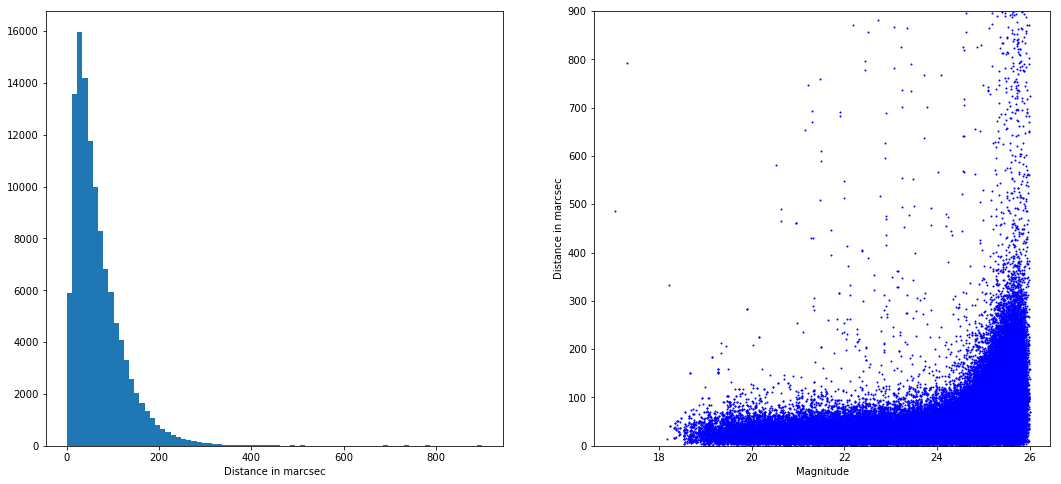

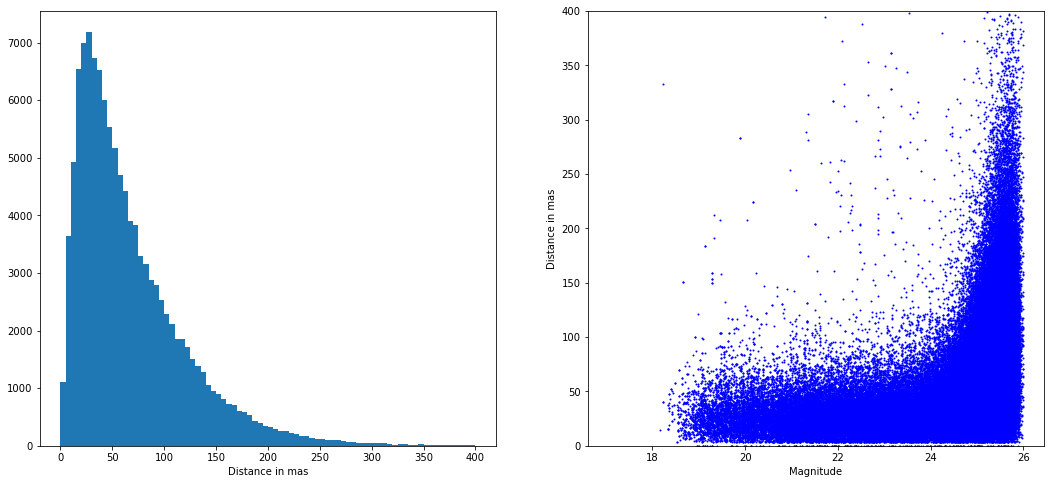

Median value of the astrometric scatter : 53.5897878432 mas


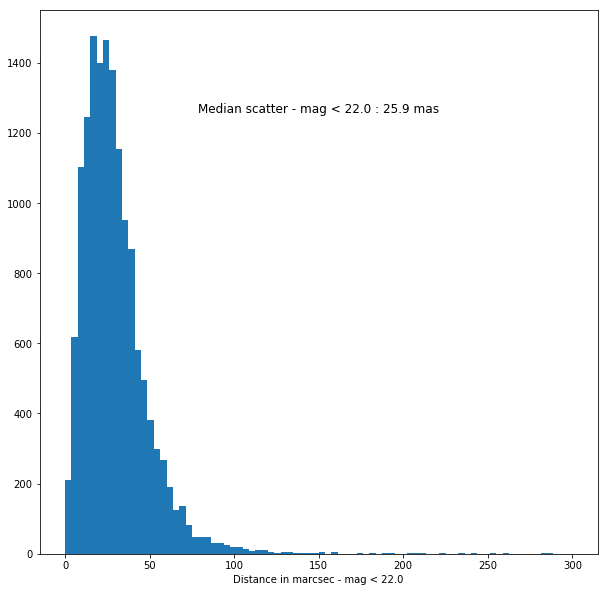

Median scatter - mag < 22.0 : 25.9 mas


In [2]:

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist, bins=80, range=[0.,900.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist,bins=80, range=[0.,400.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print("Median value of the astrometric scatter :", np.median(oldDist), "mas")

magLim = 22
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(oldDist)[idxs], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),x=0.5, y=0.8)
plt.show()

print("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])))

### Plot results for astrometric solution from the simultaneous fit

Median value of the astrometric scatter : 43.583070977 mas
Astrometric scatter (median) - mag < 22.0 : 5.4 mas


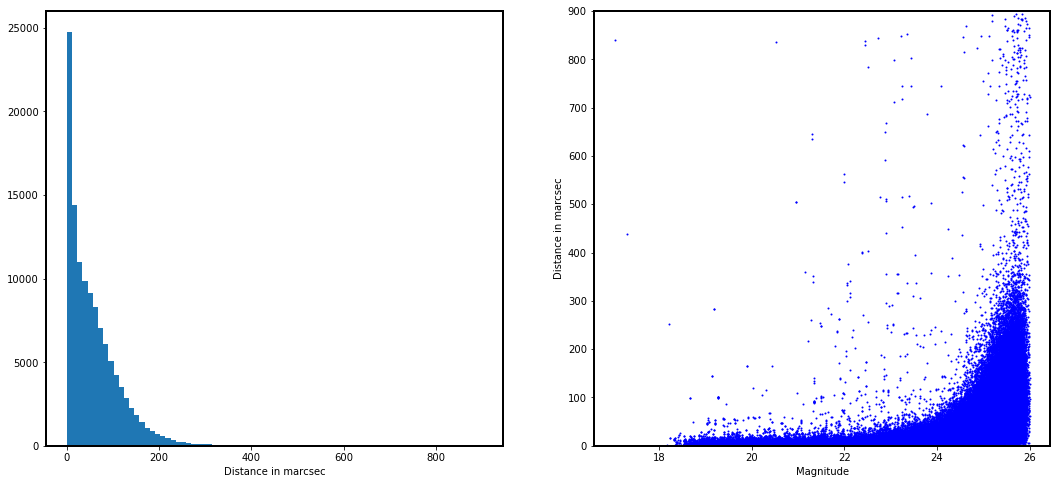

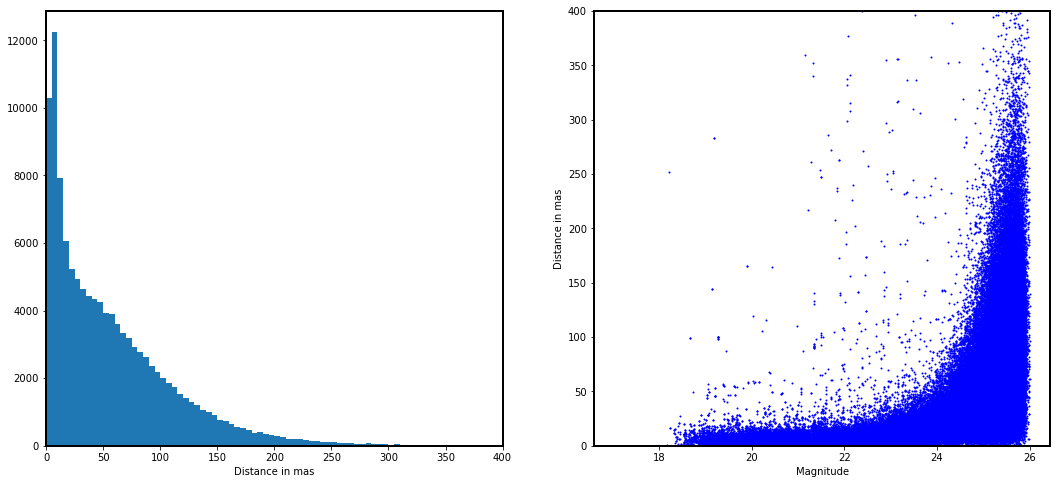

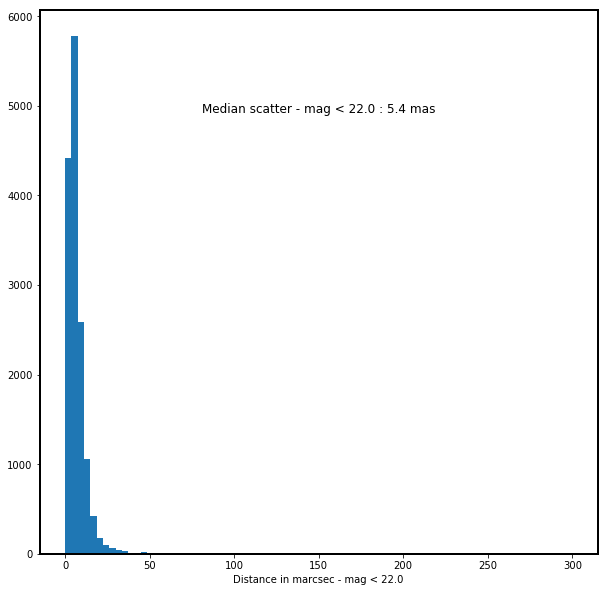

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist, bins=80, range=[0., 900.])
ax1.scatter(mag, newDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist,bins=80, range=[0., 400.])
ax0.set_xlim([0.,400.])
ax1.scatter(mag, newDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")

print("Median value of the astrometric scatter :", np.median(newDist), "mas")

magLim = 22
idxs2 = np.where(np.asarray(mag) < magLim)
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs2], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs2])),x=0.5, y=0.8)

print("Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs2])))

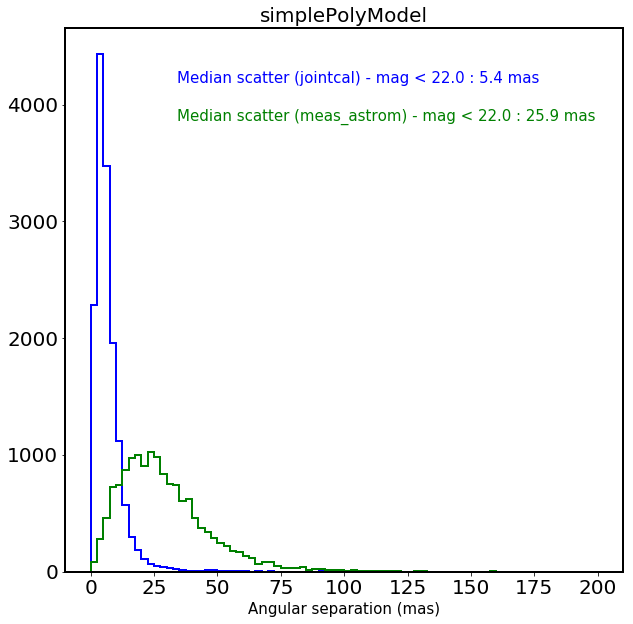

In [4]:
font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 2 
plt.rcParams['mathtext.default'] = 'regular'

fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs2], bins=80, range=[0., 200.], color='b', histtype = 'step', lw=2)
ax0.set_xlabel("Angular separation (mas)", fontsize=15)

ax0.hist(np.asarray(oldDist)[idxs2], bins=80, range=[0., 200.], color='g', histtype = 'step', lw=2)
ax0.tick_params(labelsize=20)

ax0.set_title("simplePolyModel", fontsize=20)
ax0.annotate("Median scatter (jointcal) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs2])),
             fontsize=15, color='b', xy=(0.2, 0.9), xycoords='axes fraction')
ax0.annotate("Median scatter (meas_astrom) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),
             fontsize=15, color='g', xy=(0.2, 0.83), xycoords='axes fraction')

fig.savefig("Astrometry_SPM_new.png")

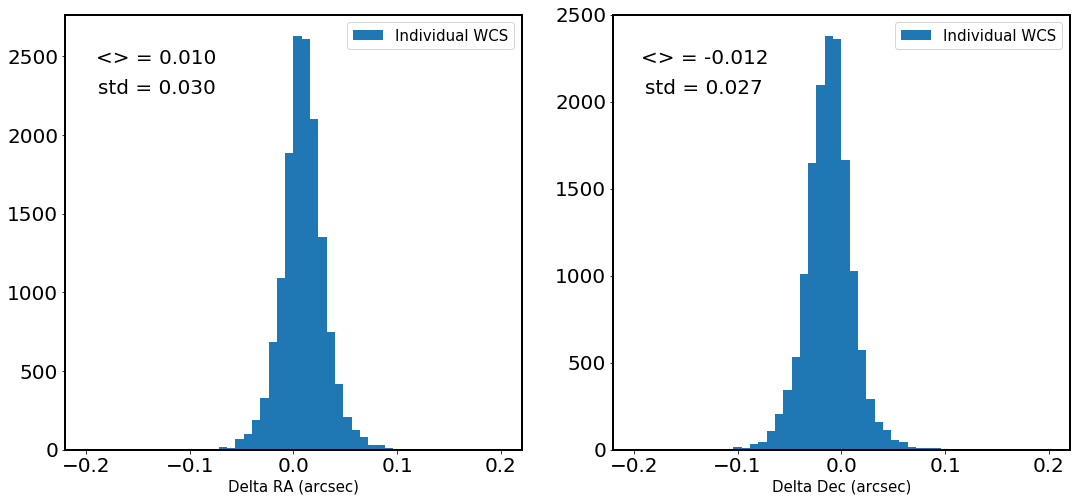

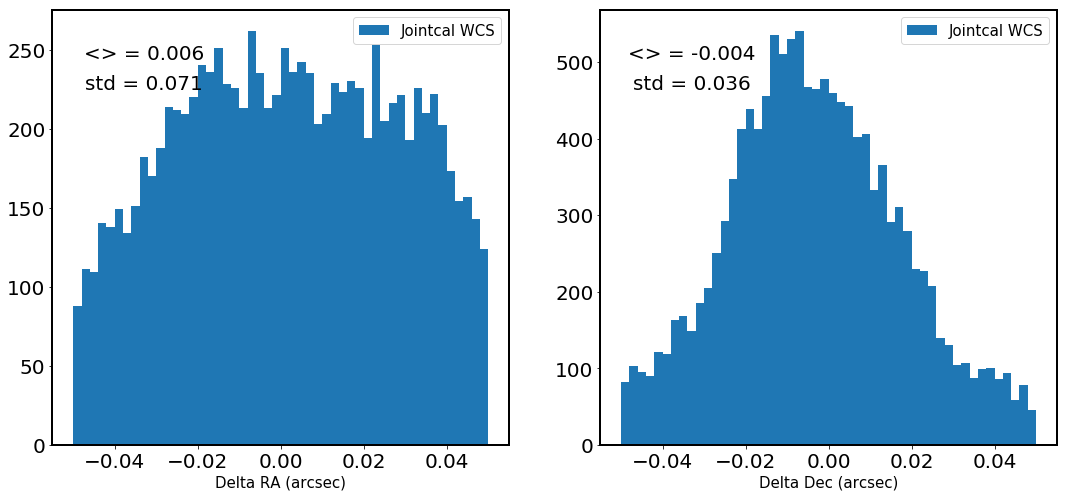

In [18]:
# Plot distance between sources for RA and Dec separately

oldAvRa = np.mean(np.asarray(oldRaDif)[idxs2])
oldAvDec = np.mean(np.asarray(oldDecDif)[idxs2])
oldSigRa = np.std(np.asarray(oldRaDif)[idxs2])
oldSigDec = np.std(np.asarray(oldDecDif)[idxs2])

newAvRa = np.mean(np.asarray(newRaDif)[idxs2])
newAvDec = np.mean(np.asarray(newDecDif)[idxs2])
newSigRa = np.std(np.asarray(newRaDif)[idxs2])
newSigDec = np.std(np.asarray(newDecDif)[idxs2])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(np.asarray(oldRaDif)[idxs2], bins=50, range=[-0.2, 0.2], label='Individual WCS')
ax1.hist(np.asarray(oldDecDif)[idxs2], bins=50, range=[-0.2, 0.2], label='Individual WCS')
ax0.legend(fontsize=15)
ax1.legend(fontsize=15)
ax0.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)
ax0.set_xlabel("Delta RA (arcsec)", fontsize=15)
ax1.set_xlabel("Delta Dec (arcsec)", fontsize=15)
ax0.text(0.2,0.9,'<> = %0.3f'%oldAvRa,horizontalalignment='center',
     verticalalignment='center', transform = ax0.transAxes, fontsize=20)
ax0.text(0.2,0.83,'std = %0.3f'%oldSigRa,horizontalalignment='center',
     verticalalignment='center', transform = ax0.transAxes, fontsize=20)
ax1.text(0.2,0.9,'<> = %0.3f'%oldAvDec,horizontalalignment='center',
    verticalalignment='center', transform = ax1.transAxes, fontsize=20)
ax1.text(0.2,0.83,'std = %0.3f'%oldSigDec,horizontalalignment='center',
     verticalalignment='center', transform = ax1.transAxes, fontsize=20)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(np.asarray(newRaDif)[idxs2], bins=50, range=[-0.05, 0.05], label='Jointcal WCS')
ax1.hist(np.asarray(newDecDif)[idxs2], bins=50, range=[-0.05, 0.05], label='Jointcal WCS')
ax0.legend(fontsize=15)
ax1.legend(fontsize=15)
ax0.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)
ax0.set_xlabel("Delta RA (arcsec)", fontsize=15)
ax1.set_xlabel("Delta Dec (arcsec)", fontsize=15)
ax0.text(0.2,0.9,'<> = %0.3f'%newAvRa,horizontalalignment='center',
     verticalalignment='center', transform = ax0.transAxes, fontsize=20)
ax0.text(0.2,0.83,'std = %0.3f'%newSigRa,horizontalalignment='center',
     verticalalignment='center', transform = ax0.transAxes, fontsize=20)
ax1.text(0.2,0.9,'<> = %0.3f'%newAvDec,horizontalalignment='center',
    verticalalignment='center', transform = ax1.transAxes, fontsize=20)
ax1.text(0.2,0.83,'std = %0.3f'%newSigDec,horizontalalignment='center',
     verticalalignment='center', transform = ax1.transAxes, fontsize=20)

In [16]:
oldRaDif[123].asArcseconds()

0.08509688132935397

In [27]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

dataid = {'visit':1204, 'filter':'HSC-R', 'ccd':10}
dataid2 = {'visit':1204, 'filter':'HSC-R', 'ccd':10, 'tract':0 }

butler = dafPersist.Butler("/sps/lsst/users/lsstprod/hsc/SSP_UDEEP_COSMOS/output")

exp = butler.get('calexp', dataid2, immediate=True)
wcsCont = butler.get('wcs', dataid2, immediate=True)
newWcs = wcsCont.getWcs()
src = butler.get('src', dataid, immediate=True)

md = butler.get("calexp_md",dataid, immediate=True)
oldWcs = afwGeom.makeSkyWcs(md)

oldCoord = src[10].getCoord()
print(oldCoord.getRa(), oldCoord.getDec())
oldRa = src[10].getRa()
oldDec = src[10].getDec()
print("old Coord", oldCoord)

pixels = oldWcs.skyToPixel(oldCoord)
cc = oldWcs.pixelToSky(pixels).toIcrs()
print("Coord with reverse transformation - old WCS", cc)
print("pixels with old wcs", pixels)
newCoord = newWcs.pixelToSky(pixels).toIcrs()
newPixels = newWcs.skyToPixel(newCoord)
print("pixels with new wcs", newPixels)
print(newCoord)

point = afwGeom.Point2D(100., 200.)
newCoord = newWcs.pixelToSky(point)
pointCheck = newWcs.skyToPixel(newCoord)

print("Verif new wcs - Point", point, "should be equal to ", pointCheck)

point = afwGeom.Point2D(100., 200.)
oldCoord = oldWcs.pixelToSky(point)
pointCheck = oldWcs.skyToPixel(oldCoord)

print("Verif old wcs - Point", point, "should be equal to ", pointCheck)

2.62795 rad 0.029782 rad
old Coord IcrsCoord(150.5705507, 1.7063855)
Coord with reverse transformation - old WCS IcrsCoord(150.5705506, 1.7063855)
pixels with old wcs (1797.9, 16.2)
pixels with new wcs (1797.9, 16.2)
IcrsCoord(150.5704894, 1.7064158)
Verif new wcs - Point (100, 200) should be equal to  (100, 200)
Verif old wcs - Point (100, 200) should be equal to  (100, 200)


In [30]:
a = [match[i].first.get("id") for i in range(10)]
print a

[122639007271092226, 122639007271092225, 122639007271092229, 122639007271092232, 122639007271092230, 122639007271092231, 122639007271092233, 122639007271092234, 122639007271094277, 122639007271092235]


In [48]:
from astropy.table import Table

row = (1, 0.01, 99756, 12)
T = Table(names=("id", "dist", "visit", "ccd"), dtype=('i','f', 'i', 'i2'))
T.add_row(row)

In [49]:
print T

 id dist visit ccd
--- ---- ----- ---
  1 0.01 99756  12


In [68]:
print dir(m.first.getCoord())
print m.first.getCoord().getRaStr(afwGeom.degrees)

['__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__eq__', '__format__', '__getattr__', '__getattribute__', '__getitem__', '__hash__', '__init__', '__iter__', '__len__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_eq_impl', '_ne_impl', '_s', 'angularSeparation', 'cast', 'clone', 'convert', 'getClassName', 'getCoordNames', 'getCoordSystem', 'getDec', 'getDecStr', 'getEpoch', 'getLatitude', 'getLatitudeStr', 'getLongitude', 'getLongitudeStr', 'getOffsetFrom', 'getPosition', 'getRa', 'getRaStr', 'getTangentPlaneOffset', 'getVector', 'offset', 'reset', 'rotate', 'this', 'toEcliptic', 'toFk5', 'toGalactic', 'toIcrs', 'toTopocentric', 'transform']
214:38:18.46


In [86]:
T_id.pprint(max_lines=-1, max_width=-1)

 id    dist  visit  ccdRef ccdVis   mag        ra          dec     
---- ------- ------ ------ ------ ------- ------------ ------------
  12 56.0724 849375     15      6 19.4281 214.45880604 52.943628666
  12 54.8817 895369     15      6 19.4281 214.45880604 52.943628666
  19 76.6486 996230     20     20 16.9974 215.16896805 52.469354778
  21 52.9027 996230     18     18 19.2935 215.64961410 52.469861397
  46 50.0215 895369     19     19 18.6904 215.41656840 52.472093620
  46 99.4576 996230     19     19 18.6904 215.41656840 52.472093620
  70 64.3053 996230     34     34 19.4156 214.25351982 52.214964677
 116 50.7055 918238     28     28 19.2717 215.36959154 52.221639429
 116 64.1539 996230     28     28 19.2717 215.36959154 52.221639429
 116 50.4403 996230     33     33 18.8921 214.47586343 52.221809901
 164 55.3564 849375     14      5 18.6382 214.62633761 52.926863183
 164 98.6145 895369     14      5 18.6382 214.62633761 52.926863183
 164 57.8863 918238     14     14 18.6382 214.62

In [ ]:
if refMag<22 and newAngle>50 :
        ra = afwGeom.Angle.asDegrees(m.first.getCoord().getRa())
        dec = afwGeom.Angle.asDegrees(m.first.getCoord().getDec())
        T.add_row((m.first.get("id"), newAngle, ang, v, ccdRef, ccdVis, refMag, ra, dec))

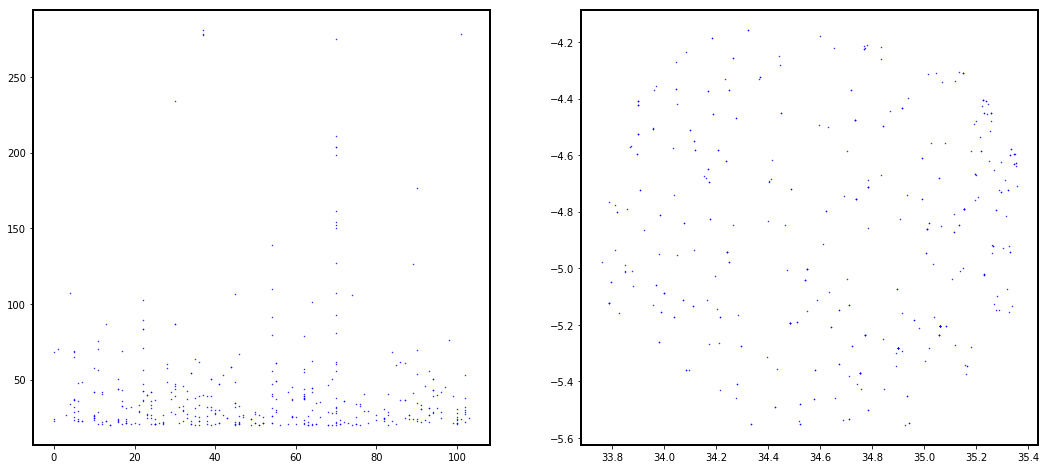

In [48]:
f1 = (T['mag'] < 20) & (T['dist'] > 20) & (T['dist'] < 400)
f2 = (T['mag'] < 20) & (T['dist'] > 20)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.scatter(T['ccdVis'][f1], T['dist'][f1], s=0.2, color='b')
ax1.scatter(T['ra'][f2], T['dec'][f2], s=0.2, color='b')